In [2]:
import glob
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import aqi_calculations.aqi_calculator as aqc
%matplotlib inline

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Константы

In [8]:
USE_COLUMNS = ['Countrycode', 'AirQualityStation', 'SamplingPoint', 'SamplingProcess', 'UnitOfMeasurement', 'Concentration', 'AveragingTime', 'DatetimeEnd', 'Validity', 'Verification']
CSV_PATH = '../../datasources/pollutants_source/$pollutant_id$/'
CSV_EDA_CLEANUP_RES_PATH = '../../datasources/eda_cleanup_res/'
CSV_AQI_PATH = '../../datasources/aqi_calc/'
CSV_FILTER = "*.csv"
POL_ID_PARAM = '$pollutant_id$'
POL_CODES = [7, 6001, 5, 8]
#POL_NAMES = {7: "O3", 6001: "PM2.5", 5: "PM10", 10: "CO", 1: "SO2", 8: "NO2"}
POL_NAMES = {7: "O3", 6001: "PM2.5", 5: "PM10", 8: "NO2"}
POL_MEASURES = {7: "µg/m3", 6001: "µg/m3", 5: "µg/m3", 10: "mg/m3", 1: "µg/m3", 8: "µg/m3"}

In [4]:
flag_data_clean_up = True

##### Загрузка csv файлов в один dataframe для каждого загрязнителя. Вывод типов данных и первых строк для первого загрязнителя

In [26]:
df_list= list()
for pol_id in POL_CODES:
    df = pd.concat(map(lambda p: pd.read_csv(p, usecols=USE_COLUMNS), glob.glob(os.path.join(CSV_PATH.replace(POL_ID_PARAM, str(pol_id)), CSV_FILTER))))
    print(f'Pollutant: {POL_NAMES[pol_id] :10}Lines count: {df.shape[0]}')
    df_list.append(df)

Pollutant: O3        Lines count: 70526
Pollutant: PM2.5     Lines count: 86933
Pollutant: PM10      Lines count: 70407
Pollutant: NO2       Lines count: 70695


In [14]:
df_list[0].head()

,Countrycode,AirQualityStation,SamplingPoint,SamplingProcess,AveragingTime,Concentration,UnitOfMeasurement,DatetimeEnd,Validity,Verification
0,NL,STA-NL00418,SPO-NL00418_00007_120,SPP-NL_A_UV-P_thermo49i,hour,40.77,µg/m3,2022-01-01 01:00:00 +01:00,1,3
1,NL,STA-NL00418,SPO-NL00418_00007_120,SPP-NL_A_UV-P_thermo49i,hour,32.71,µg/m3,2022-01-01 02:00:00 +01:00,1,3
2,NL,STA-NL00418,SPO-NL00418_00007_120,SPP-NL_A_UV-P_thermo49i,hour,12.98,µg/m3,2022-01-01 04:00:00 +01:00,1,3
3,NL,STA-NL00418,SPO-NL00418_00007_120,SPP-NL_A_UV-P_thermo49i,hour,7.50,µg/m3,2022-01-01 05:00:00 +01:00,1,3
4,NL,STA-NL00418,SPO-NL00418_00007_120,SPP-NL_A_UV-P_thermo49i,hour,16.29,µg/m3,2022-01-01 06:00:00 +01:00,1,3


***
#### Общая статистика по каждому загрязнителю
***

In [ ]:
for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    display(df_list[i].describe(include='all'))

**Выводы:**
1. В столбце Concentration встречаются пропущенные значения. Необходимо оценить их долю и оставить для сохранения временных интервалов и последующего анализа.
2. Есть невалидированные данные (Validity <= 0 или не определено). Необходимо оценить их долю. В соответствии с документацией к датасету, невалидными являются данные за пределами измерений приборов и проч. В данной работы не стоит цель оценки качества работы приборов, поэтому такие концентрации необходимо заменить на NaN и рассматривать впоследствии как отсутствующие.
3. Есть неверифицированные или непрошедшие полный процесс верификации данные (Verification != 1). Необходимо оценить их долю. Такие данные не должны входить в формальные отчеты. Но в нашей учебной работе исключать их необходимости нет.
4. Минимальные значения Concentration меньше нуля или равны нулю. Это не имеет физического смысла. Но в соответствии с некоторыми найденными регламентами можно утверждать, что в датасетах допускается небольшое количество отрицательных значений (если так отработал датчик, а показания надо сдавать). Необходимо проанализировать распределение отрицательных концентраций. Значения в близи нуля требуется привести к нулю, считая приборной погрешностью. Значения существенно выше нуля, можно счесть невалидными и проставить для них NaN.
5. Максимальные значения Concentration на один-два порядка превышают средние и квантили, что указывает на выбросы. Необходимо оценить долю выбросов. Если таковых немного, то необходимо будет отделить выбросы от основного датасета и рассматривать их отдельно.
6. На каждый загрязнитель имеется только одно значение для UnitOfMeasurement, значит не понадобится приводить единицы измерения, и столбец необходимо удалить.
7. Для всех загрязнителей, кроме PM2.5, имеется только один тип временного интервала измерения концентраций - по часам (столбец AveragingTime). В случае с PM2.5 требуется проанализировать, каким является второй тип интервала. Если он окажется больше часа и кратным часу, то необходимо дополнить датасет строками на каждый час в интервале с концентрациями Nan и другими значениями взятыми из строки отличным от часа интервалом.

***
#### Оценка и удаление пропущенных, невалидных, неверифицированных значений. Проверки столбцов и их удаление
***

In [9]:
def get_all_lines_count():
    return sum(x.shape[0] for x in df_list)

def print_pol_portion(p_id, part, full=None):
        if full is not None:
            print(f'    Загрязнитель   {POL_NAMES[POL_CODES[p_id]]:8} {round(part/full*100, 2)}% значений')
        else:
            print(f'    Загрязнитель   {POL_NAMES[POL_CODES[p_id]]:8} {part} значений')

def print_all_poll_portion(part, full):
    print(f'По всем загрязнителям: {round(part/full*100, 2)} %')

def print_pol_divider(p_id):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[p_id]]}--------------------------------------------')

##### Проверка на полные дубликаты. Удаление

In [34]:
def check_duplicates_by_group(columns = None):
    print(f'Количество дублированных строк по загрязнителям:')
    for i in range(len(POL_CODES)):
        dubl_count = df_list[i].duplicated(keep=False).sum() if (columns is None) else df_list[i].duplicated(subset=columns, keep='last').sum()
        print_pol_portion(i, dubl_count, df_list[i].shape[0])
        if flag_data_clean_up:
            df_list[i].drop_duplicates(inplace=True)

def check_duplicates_count(columns, limits):
    print(f'Проверка строк с кол-вом различных концентраций > {limits} для группы строк {columns}')
    flag_dif_val = False
    for i in range(len(POL_CODES)):
        df_temp = df_list[i].groupby(columns,as_index=False, sort=False).size()
        for limit in limits:
            df_dif_val = df_temp[df_temp['size'] > limit]
            if df_dif_val.shape[0] > 0:
                print_pol_divider(i)
                print(f'Лимит > {limit}')
                flag_dif_val = True
                display(df_dif_val)
    if not flag_dif_val:
        print(f'Не найдены строки с кол-вом различных концентраций > {limits} для группы строк {columns}')

def check_duplicates_for_station_dif_values():
    print(f'проверка, что на если на станции применяется 2 SamplingProcess, то значения концентрации одинаковы:')
    for i in range(len(POL_CODES)):
        gr = (df_list[i].groupby(['AirQualityStation', 'DatetimeEnd', 'Concentration']).count())['SamplingProcess']
        print(f'{POL_NAMES[POL_CODES[i]]} != 2: {gr[gr > 2].any()}')

def check_duplicates_for_station_dif_values():
    for i in range(len(POL_CODES)):
        gr = (df_list[i].groupby(['AirQualityStation', 'DatetimeEnd', 'Concentration']).count())['SamplingProcess']
        print(f'    {POL_NAMES[POL_CODES[i]]} != 2: {gr[gr > 2].any()}')

def drop_sampling_process_duplicates():
    if flag_data_clean_up:
        for i in range(len(POL_CODES)):
            df_list[i] = df_list[i].sort_values('SamplingProcess').drop_duplicates(subset=['AirQualityStation', 'DatetimeEnd', 'Concentration'], keep='last')

def drop_sampling_unverified_duplicates():
    if flag_data_clean_up:
        for i in range(len(POL_CODES)):
            df_list[i] = df_list[i].sort_values('Verification').drop_duplicates(subset=['AirQualityStation', 'DatetimeEnd'], keep='first')

In [15]:
check_duplicates_by_group(['AirQualityStation', 'DatetimeEnd'])

Количество дублированных строк по загрязнителям:
    Загрязнитель   O3       0.0% значений
    Загрязнитель   PM2.5    19.16% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений


In [16]:
check_duplicates_by_group(['AirQualityStation', 'DatetimeEnd', 'SamplingProcess'])

Количество дублированных строк по загрязнителям:
    Загрязнитель   O3       0.0% значений
    Загрязнитель   PM2.5    0.0% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений


In [33]:
drop_sampling_unverified_duplicates()
check_duplicates_by_group(['AirQualityStation', 'DatetimeEnd'])

Количество дублированных строк по загрязнителям:
    Загрязнитель   O3       0.0% значений
    Загрязнитель   PM2.5    0.0% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений


##### Оценка пропущенных значений
##### Оценка строк с неуказанными концентрациями

In [35]:
all_lines_count = get_all_lines_count()
invalid_lines_count = 0
print(f'Доля значений c неуказанной концентрацией по загрязнителям:')
for i in range(len(POL_CODES)):
    dp = df_list[i][df_list[i]['Concentration'].isna()]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доля значений c неуказанной концентрацией по загрязнителям:
    Загрязнитель   O3       2.14% значений
    Загрязнитель   PM2.5    1.24% значений
    Загрязнитель   PM10     1.62% значений
    Загрязнитель   NO2      1.06% значений
По всем загрязнителям: 1.52 %


##### Оценка строк с неуказанной датой или станцией. Такие данные удаляем, мы не можем их использовать

In [24]:
all_lines_count = get_all_lines_count()
invalid_lines_count = 0
print(f'Доля значений с неуказанной датой или станцией. Будут удалены:')
for i in range(len(POL_CODES)):
    bad_mask = df_list[i]['AirQualityStation'].isna() | df_list[i]['DatetimeEnd'].isna()
    dp = df_list[i][bad_mask]
    print_pol_portion(i, dp.shape[0])
    if dp.shape[0] > 0:
        df_list[i] = df_list[i][~bad_mask]
        print(f'        {dp.shape[0]} значений удалены')
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доля значений с неуказанной датой или станцией. Будут удалены:
    Загрязнитель   O3       0 значений
    Загрязнитель   PM2.5    0 значений
    Загрязнитель   PM10     0 значений
    Загрязнитель   NO2      0 значений
По всем загрязнителям: 0.0 %


##### Оценка неверифицированных значений (за исключением пропущенных)

In [36]:
invalid_lines_count = 0
print(f'Доля неверифицированных значений (за исключением пропущенных) по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_mask = (~df_list[i]['Concentration'].isna()) & (df_list[i]['Verification'] != 1)
    dp = df_list[i][bad_mask]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доля неверифицированных значений (за исключением пропущенных) по загрязнителям:
    Загрязнитель   O3       12.99% значений
    Загрязнитель   PM2.5    25.14% значений
    Загрязнитель   PM10     12.84% значений
    Загрязнитель   NO2      13.19% значений
По всем загрязнителям: 16.03 %


##### Оценка невалидных значений (за исключением пропущенных)

In [37]:
invalid_lines_count = 0
print(f'Доли невалидных значений (за исключением пропущенных) по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_mask = (~df_list[i]['Concentration'].isna()) & (df_list[i]['Validity'] <= 0)
    dp = df_list[i][bad_mask]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доли невалидных значений (за исключением пропущенных) по загрязнителям:
    Загрязнитель   O3       0.0% значений
    Загрязнитель   PM2.5    0.0% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений
По всем загрязнителям: 0.0 %


##### Оценка нулевых значений

In [38]:
invalid_lines_count = 0
print(f'Доля нулевых значений по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_mask = df_list[i]['Concentration'] == 0
    dp = df_list[i][bad_mask]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доля нулевых значений по загрязнителям:
    Загрязнитель   O3       0.02% значений
    Загрязнитель   PM2.5    0.0% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений
По всем загрязнителям: 0.01 %


##### Оценка отрицательных значений

Доли отрицательных значений по загрязнителям:
    Загрязнитель   O3       3.21% значений
    Загрязнитель   PM2.5    1.42% значений
    Загрязнитель   PM10     3.52% значений
    Загрязнитель   NO2      0.0% значений
По всем загрязнителям: 2.04 %


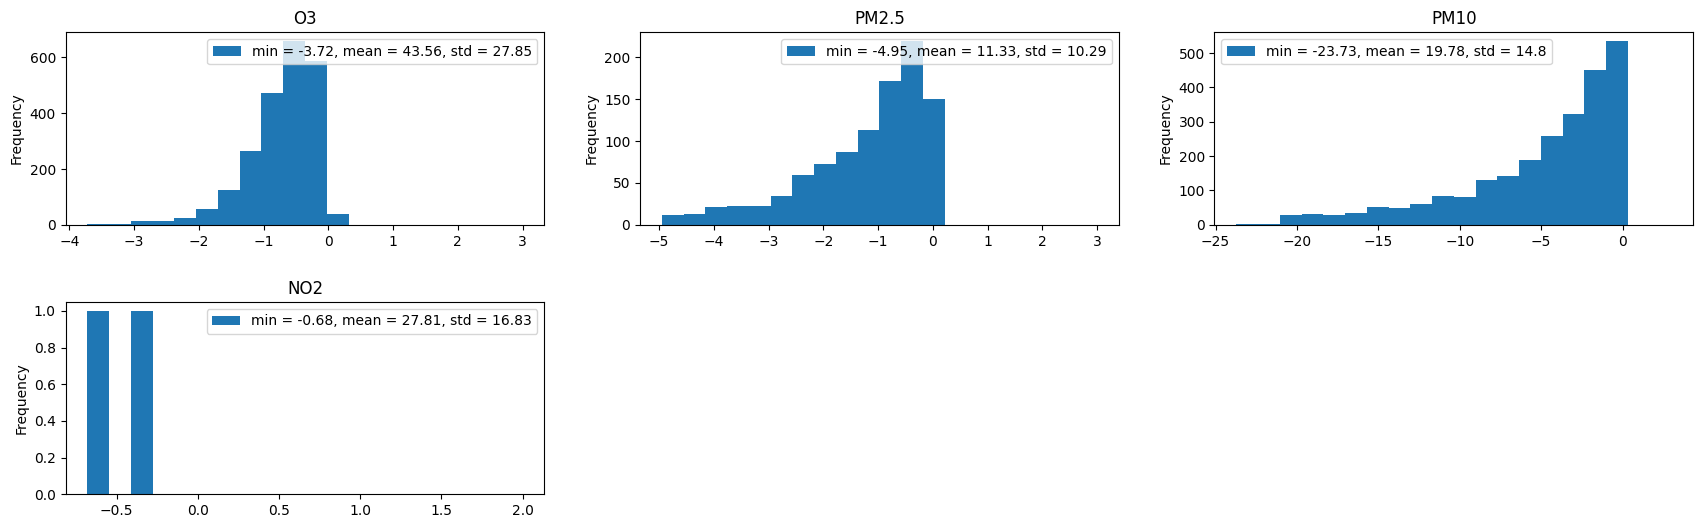

In [39]:
invalid_lines_count = 0
print(f'Доли отрицательных значений по загрязнителям:')
dp_bad = list()
df_means = list()
df_stds = list()

for i in range(len(POL_CODES)):
    bad_mask = df_list[i]['Concentration'] < 0
    dp = df_list[i][bad_mask]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
    dp_bad.append(dp)
print_all_poll_portion(invalid_lines_count, all_lines_count)

fig = plt.figure(figsize=(21, 6))
for i in range(len(POL_CODES)):
    axn = fig.add_subplot(231 + i)
    dfmean = df_list[i]["Concentration"].mean()
    df_means.append(dfmean)
    dfstd = df_list[i]["Concentration"].std()
    df_stds.append(dfstd)
    dp_bad[i].plot.hist(column=['Concentration'], bins=20, title = POL_NAMES[POL_CODES[i]], ax=axn)
    plt.legend([f'min = {round(dp_bad[i]["Concentration"].min(), 2)}, mean = {round(dfmean, 2)}, std = {round(dfstd, 2)}'])

plt.subplots_adjust(hspace=0.4)

##### Отрицательные значения - к Nan.

In [40]:
if flag_data_clean_up:
    invalid_lines_count = 0
    for i in range(len(POL_CODES)):
        bad_mask = df_list[i]['Concentration'] < 0
        df_list[i].loc[bad_mask, 'Concentration'] = np.NaN

In [41]:
all_lines_count = get_all_lines_count()
invalid_lines_count = 0
print(f'Доля значений c неуказанной концентрацией по загрязнителям:')
for i in range(len(POL_CODES)):
    dp = df_list[i][df_list[i]['Concentration'].isna()]
    print_pol_portion(i, dp.shape[0], df_list[i].shape[0])
    invalid_lines_count += dp.shape[0]
print_all_poll_portion(invalid_lines_count, all_lines_count)

Доля значений c неуказанной концентрацией по загрязнителям:
    Загрязнитель   O3       5.34% значений
    Загрязнитель   PM2.5    2.66% значений
    Загрязнитель   PM10     5.15% значений
    Загрязнитель   NO2      1.06% значений
По всем загрязнителям: 3.55 %


##### Проверка временных интервалов измерения отличных от 1 часа. Оценка доли таких интервалов.

In [42]:
import warnings

non_hour_lines_count = 0
df_df_days = list()
print(f'Доли интервалов, неравных 1 часу, по загрязнителям:')
for i in range(len(POL_CODES)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
        df_list[i]['DatetimeEnd'] = pd.to_datetime(df_list[i]['DatetimeEnd'])
    no_hour_mask = df_list[i]['AveragingTime'] != 'hour'
    df_hour_dif = df_list[i][no_hour_mask]
    print_pol_portion(i, df_hour_dif.shape[0], df_list[i].shape[0])
    non_hour_lines_count += df_hour_dif.shape[0]
    if df_hour_dif is not None and df_hour_dif.shape[0] > 0:
        df_df_days.append(df_hour_dif)
        print(f'Другой интервал: {df_hour_dif["AveragingTime"].unique()}')
    else:
       df_df_days.append(None)

Доли интервалов, неравных 1 часу, по загрязнителям:
    Загрязнитель   O3       0.0% значений
    Загрязнитель   PM2.5    0.0% значений
    Загрязнитель   PM10     0.0% значений
    Загрязнитель   NO2      0.0% значений


##### Замена дневных интервалов на часовые, заполнение, NaN - для концентраций

In [43]:
def get_hour_columns(df_days):
    df_days.assign(AveragingTime = 'hour')
    df_days.assign(Concentration = np.NaN)
    df_dub = df_days.loc[df_days.index.repeat(23),:]
    df_range = df_days.loc[:,'DatetimeEnd'].apply(lambda x: pd.date_range(x - pd.Timedelta(hours=23), x - pd.Timedelta(hours=1), freq='1h'))
    df_dub['DatetimeEnd'] = df_range.explode()
    return df_dub

In [23]:
if flag_data_clean_up:
    for i in range(len(POL_CODES)):
        if df_df_days[i] is None:
            continue
        df_list[i] = pd.concat([df_list[i], get_hour_columns(df_df_days[i])], axis=0, ignore_index=True)

##### Удаление столбцов Verification, Validity, UnitOfMeasurement, AveragingTime, SamplingPoint

In [46]:
for i in range(len(POL_CODES)):
    df_list[i] = df_list[i].drop(columns= ['AirQualityStation', 'Verification', 'Validity', 'UnitOfMeasurement', 'AveragingTime', 'SamplingPoint', 'SamplingProcess', 'Countrycode'])

##### Индексация

In [50]:
for i in range(len(POL_CODES)):
    df_list[i].set_index("DatetimeEnd", inplace=True)
    df_list[i].sort_index(inplace=True)
df_list[0].head()

,Concentration
DatetimeEnd,
2015-01-01 01:00:00+01:00,6.94
2015-01-01 02:00:00+01:00,13.77
2015-01-01 03:00:00+01:00,12.85
2015-01-01 04:00:00+01:00,13.19
2015-01-01 05:00:00+01:00,7.75


##### Сохранение обработанных данных

In [52]:
for i in range(len(POL_CODES)):
    file_path = os.path.join(CSV_EDA_CLEANUP_RES_PATH, f'{POL_CODES[i]}.csv')
    df_list[i].to_csv(file_path)

##### Графики очищенных данных

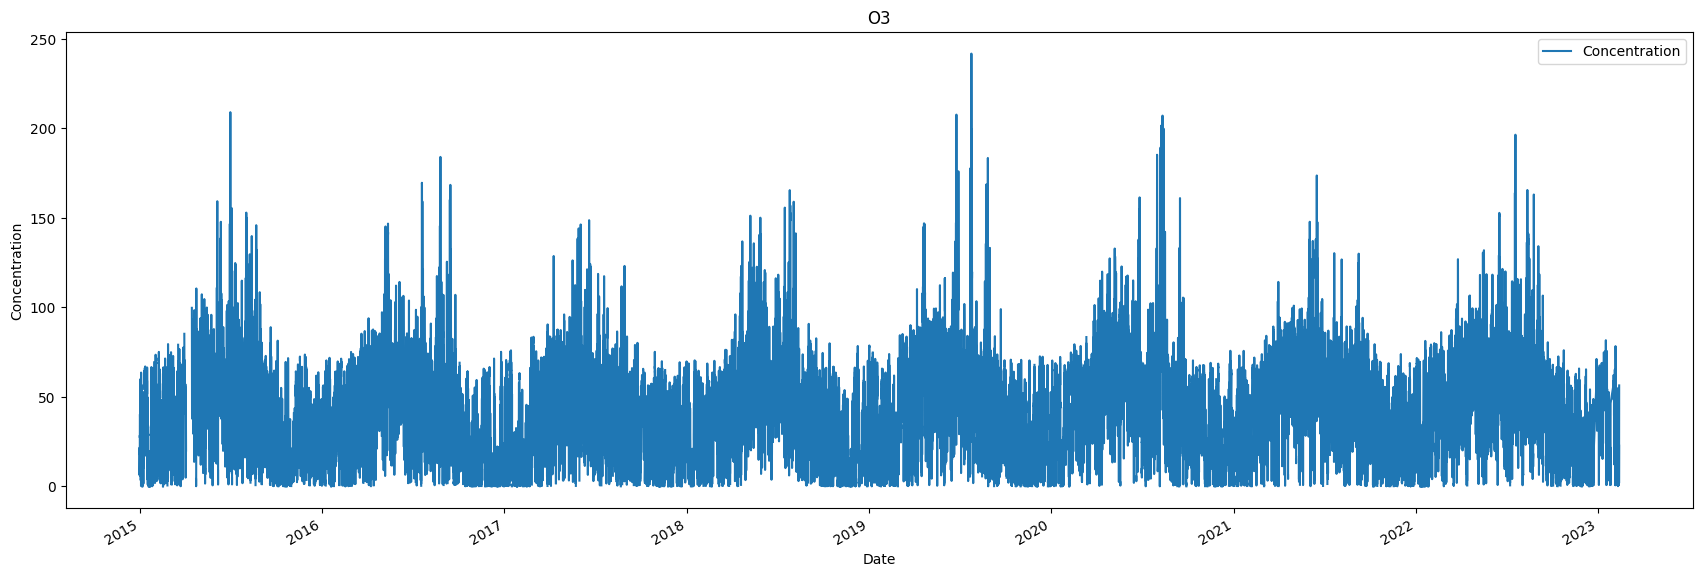

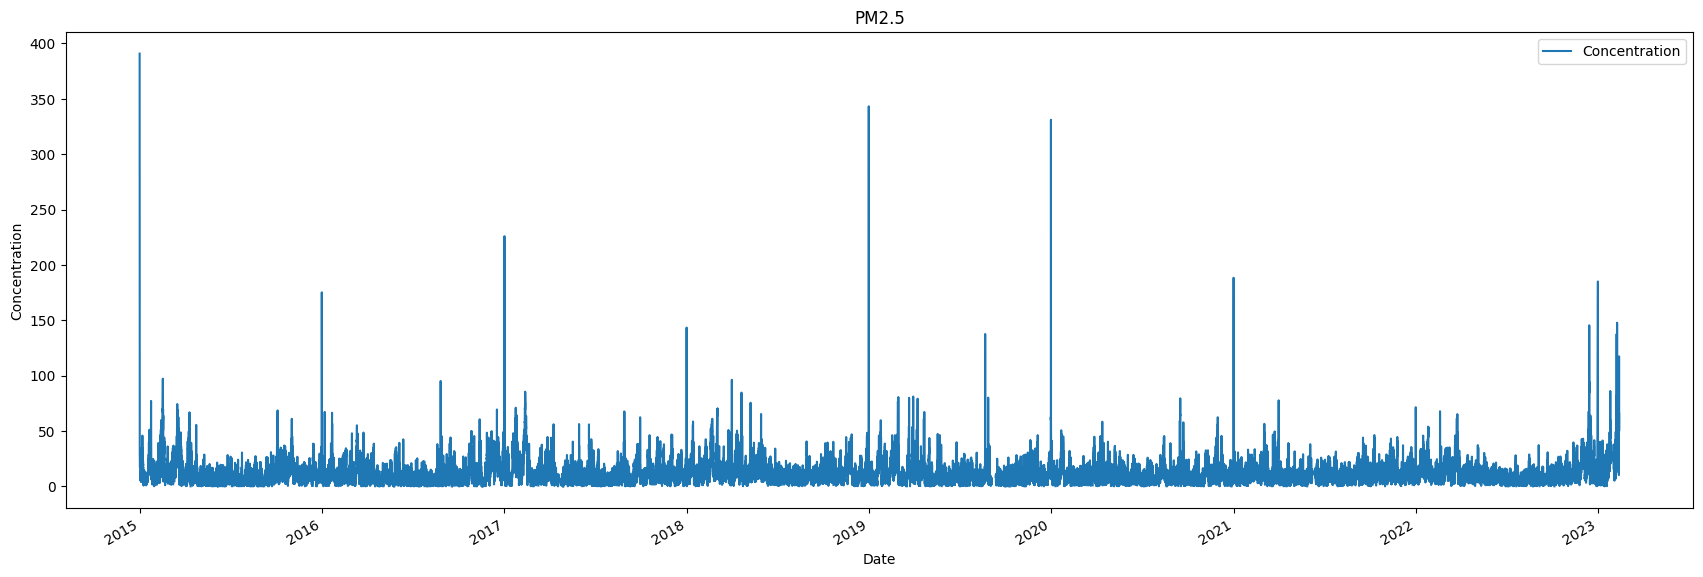

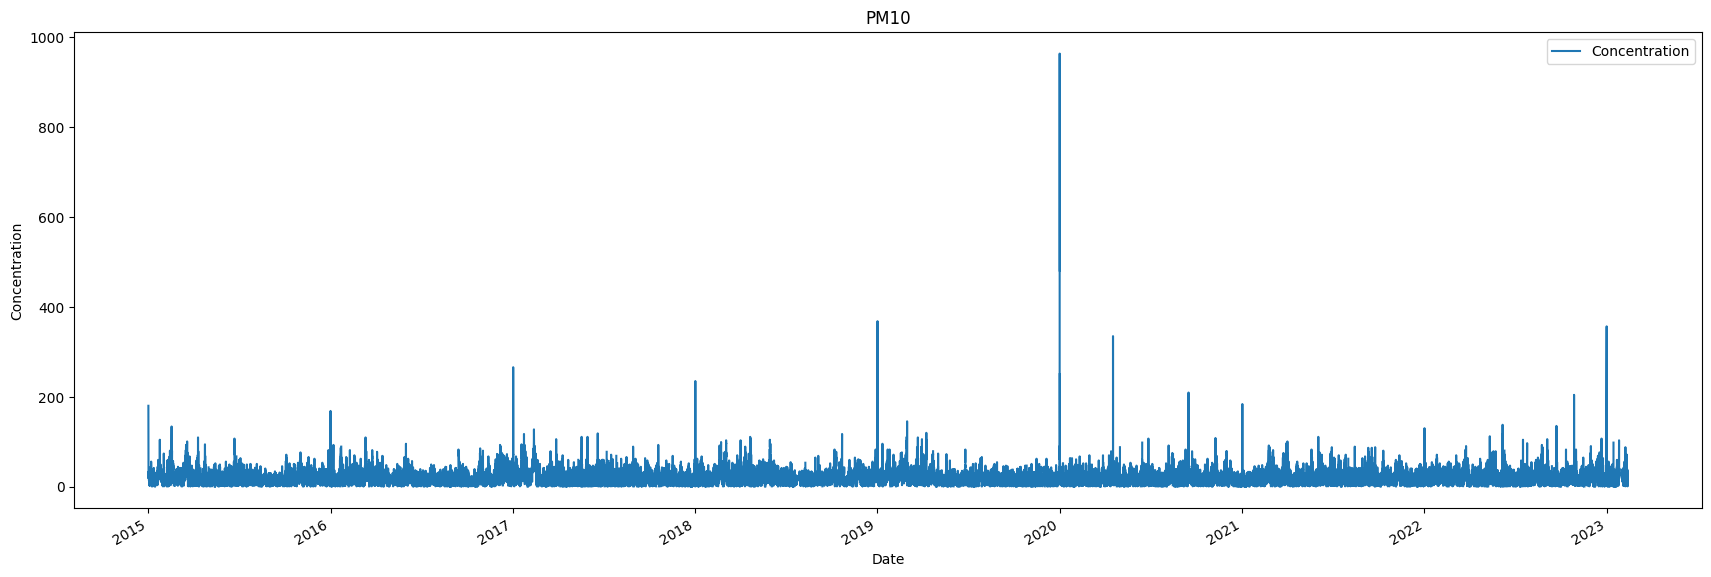

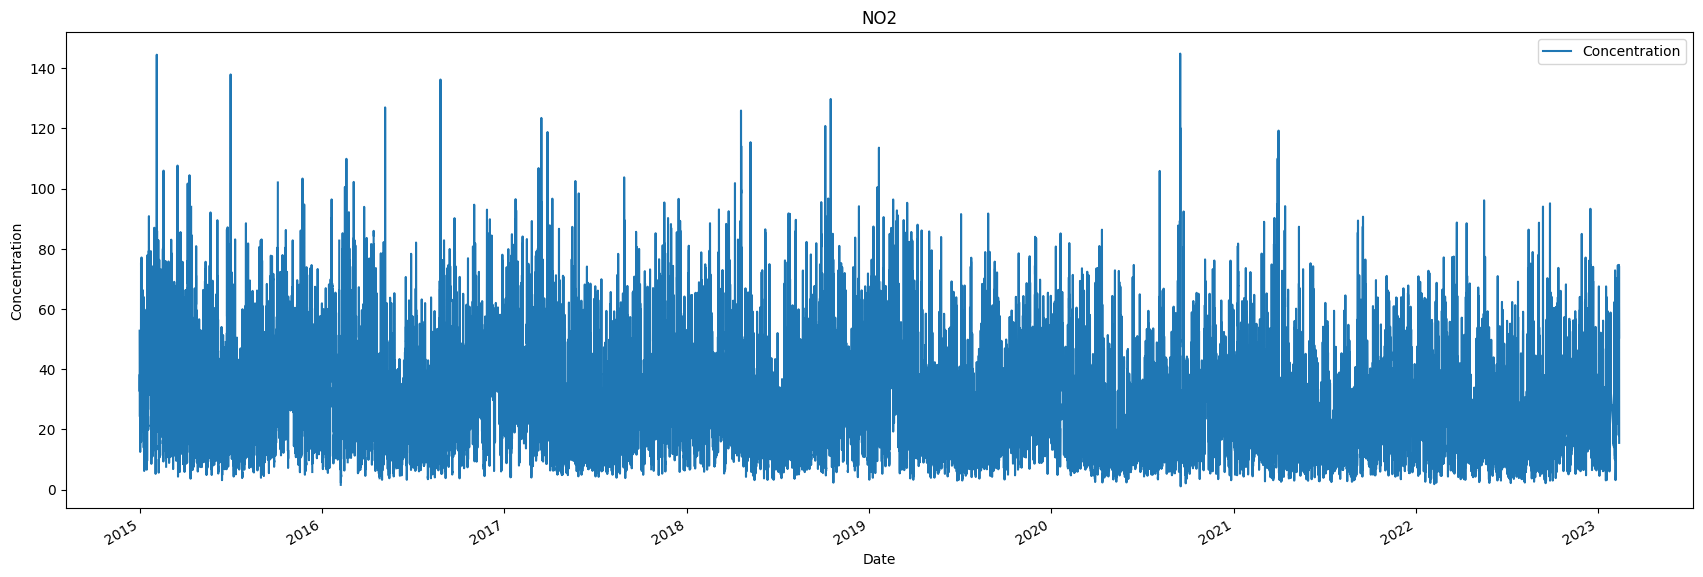

In [51]:
for i in range(len(POL_CODES)):
    axs = plt.gca()
    df_list[i].plot(xlabel="Date", ylabel="Concentration", title=POL_NAMES[POL_CODES[i]],  y='Concentration', c='tab:blue', figsize=(21,7), ax=axs)
    plt.show()

**Выводы:**
1. Были удалены данные с пропущенными значениями кода станции и временного интервала, их невозможно использовать.
2. Приведены оценки доли пропущенных, невалидных, отрицательных и нулевых значений концентраций.
3. Все единицы измерения в рамках загрязнителя одинаковы, столбец не несет полезной информации и был удален.
4. Временной интервал измерения за редким исключением составляет 1 час (менее 1% для PM2.5- это интервалы в 1 день). Чтобы не искажать результаты последующих расчетов, строки с интервалов в день были дополнены строками в количестве 23 на каждый час на сутки до DatetimeEnd с теми же данными, кроме концентраций (для них указано значение NaN)
5. Поскольку был зафиксирован интервал измерений длительностью в 1 час, один из столбцов с интервалом даты не несет полезной информации, поэтому столбец DatetimeBegin был удален.
6. Была обнаружена большая часть полностью одинаковых строк. Анализ csv файла датасета показал, что одинаковым строкам соответствуют различные методы измерения, которые у нас в расчет не берутся. При этом проверено, что концентрации для разных методов в датасетах одинаковы. Для данной работы подобные дубликаты не несут никакой полезной информации, потому они были удалены

***
#### Расчет индексов качества воздуха, сворачивание данных по дням
***

In [53]:
for i in range(len(POL_CODES)):
    pollutant_id = POL_CODES[i]
    measure = POL_MEASURES[pollutant_id]
    df_p = pd.read_csv(os.path.join(CSV_EDA_CLEANUP_RES_PATH, f'{pollutant_id}.csv'), parse_dates=True, index_col='DatetimeEnd')
    g = aqc.calc_aqi_for_day_pd(pollutant_id, df_p, measure)
    file_path = os.path.join(CSV_AQI_PATH, f'{POL_CODES[i]}.csv')
    g.to_csv(file_path)

#### Графики индексов качества воздуха по загрязнителям

In [9]:
df_aqi_list = []
for pol_id in POL_CODES:
    file_path = os.path.join(CSV_AQI_PATH, f'{pol_id}.csv')
    df_aqi_list.append(pd.read_csv(file_path, parse_dates=True, index_col='DatetimeEnd'))
df_aqi = reduce(lambda df1,df2: pd.merge(df1,df2,on='DatetimeEnd'), df_aqi_list)
df_aqi.columns = POL_NAMES.values()

/tmp/ipykernel_231135/3887133050.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AQI_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_aqi = reduce(lambda df1,df2: pd.merge(df1,df2,on='DatetimeEnd'), df_aqi_list)


<AxesSubplot:title={'center':'AQI по загрязнителям'}, xlabel='DatetimeEnd'>

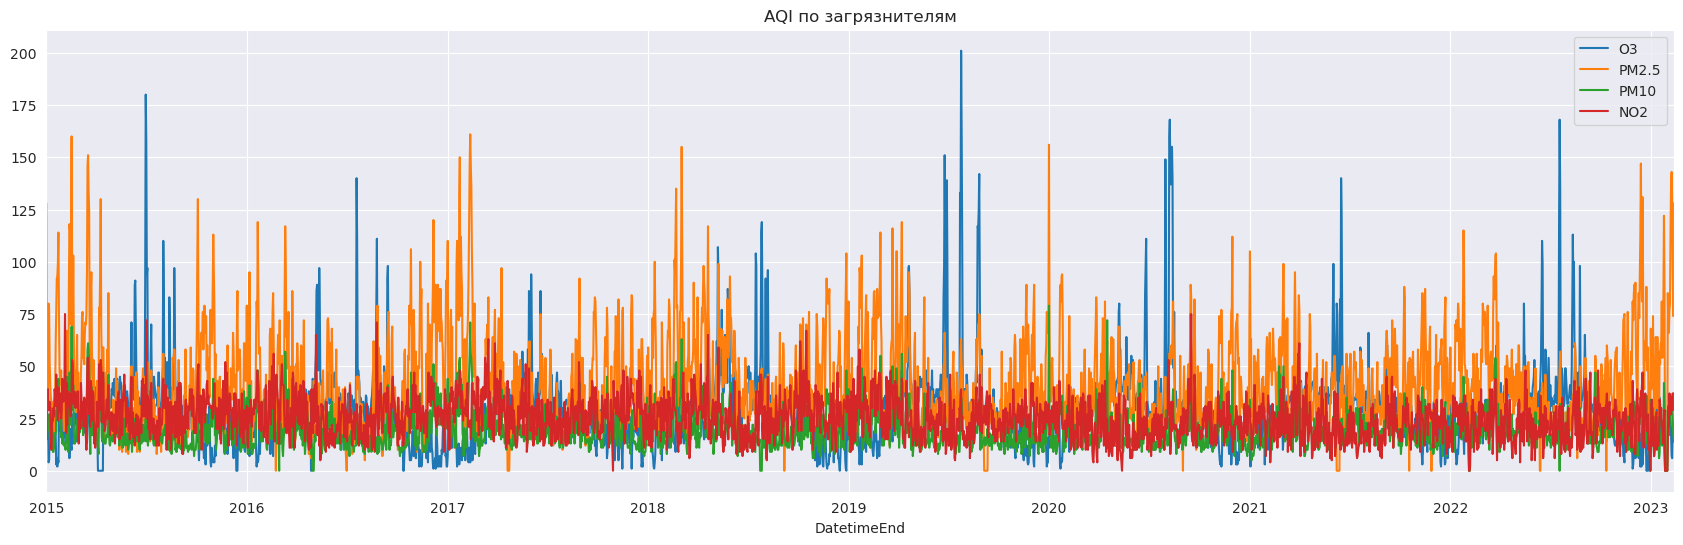

In [10]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
df_aqi.plot(ax=ax, title="AQI по загрязнителям")